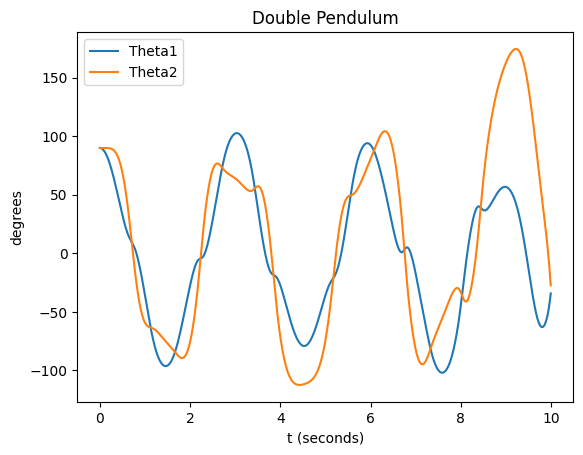

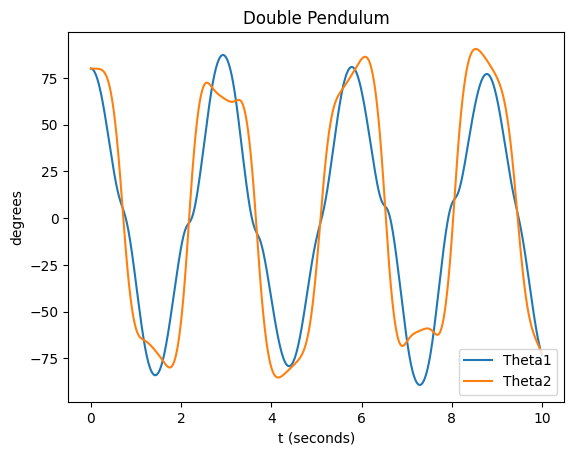

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0

def f(r, t, L1, L2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]

    ftheta1 = omega1
    fomega1 = (-g * (2 * m1 + m2) * sin(theta1) - m2 * g * sin(theta1 - 2 * theta2) - 2 * sin(theta1 - theta2) * m2 *
               (omega2**2 * L2 + omega1**2 * L1 * cos(theta1 - theta2))) / (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    ftheta2 = omega2
    fomega2 = (2 * sin(theta1 - theta2) * (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * cos(theta1) + omega2**2 * L2 * m2 *
                                           cos(theta1 - theta2))) / (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    return array([ftheta1, fomega1, ftheta2, fomega2], float)

a = 0.0
b = 10
N = 2000
h = (b - a) / N

angles = [[90, 90],[80, 80]]

for x in angles:
  tpoints = np.arange(a, b, h) # seconds, split into intervals of 100
  theta1_points = np.zeros_like(tpoints) # what the first pendulm angle should be (empty)
  theta2_points = np.zeros_like(tpoints) # what the second pendulm angle should be (empty)

  q = np.array([x[0]*pi/180, 0, x[1]*pi/180, 0], float)

  for i, t in enumerate(tpoints):
      theta1_points[i] = q[0] * 180 / pi # converted from theta (θ) to degrees (°)
      theta2_points[i] = q[2] * 180 / pi

      k1 = h * f(q, t, L1, L2)
      k2 = h * f(q + 0.5 * k1, t + 0.5 * h, L1, L2)
      k3 = h * f(q + 0.5 * k2, t + 0.5 * h, L1, L2)
      k4 = h * f(q + k3, t + h, L1, L2)
      q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

  plt.plot(tpoints, theta1_points, label='Theta1') # what the first pendulm is (populated)
  plt.plot(tpoints, theta2_points, label='Theta2') # what the second pendulm is (populated)
  plt.title("Double Pendulum")
  plt.xlabel("t (seconds)")
  plt.ylabel("degrees")
  plt.legend()
  plt.show()

  data = np.stack((theta1_points, theta2_points), axis=1)
  np.save(f'pendulum_data_{str(x[0])}_{str(x[1])}.npy', data)

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Define the dataset class
class QuadraticDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)  # Shape (N, 2)
        self.y = torch.tensor(y, dtype=torch.float32)  # Shape (N, 2)
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].unsqueeze(0), self.y[idx]

data = {}

for i in angles:
  loaded_data = np.load(f'pendulum_data_{str(i[0])}_{str(i[1])}.npy')
  scaler = MinMaxScaler()
  data_ = scaler.fit_transform(loaded_data)
  data[f'{str(i[0])}_{str(i[1])}'] = data_


def create_io(data):
    x, x_1, x_2, y_1, y_2 = [], [], [], [], []
    # for i in angles
    for starting in data:
      starting_theta_1_degrees = int(starting.split("_")[0])
      starting_theta_2_degrees = int(starting.split("_")[1])

      starting_theta_1 = starting_theta_1_degrees * pi /180
      starting_theta_2 = starting_theta_2_degrees * pi /180

      angle_data = data[starting]
      for i in range(len(angle_data)):
          x.append(tpoints[i])
          x_1.append(starting_theta_1)
          x_2.append(starting_theta_2)
          y_1.append(angle_data[i][0])
          y_2.append(angle_data[i][1])
    return x, x_1, x_2, y_1, y_2

x, x_1, x_2, y_1, y_2 = create_io(data)

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Combine x_1 and x_2 into one feature matrix
x_combined = np.vstack([x_1, x_2, x]).T
x_scaled = scaler_x.fit_transform(x_combined)

# Combine y_1 and y_2 into one target matrix
y_combined = np.vstack([y_1, y_2]).T
y_scaled = scaler_y.fit_transform(y_combined)

# Create dataset and dataloaders
dataset = QuadraticDataset(x_scaled, y_scaled)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

Epoch 1, Train Loss: 0.1445, Validation Loss: 0.1009
Epoch 2, Train Loss: 0.0978, Validation Loss: 0.0969
Epoch 3, Train Loss: 0.0960, Validation Loss: 0.0958
Epoch 4, Train Loss: 0.0951, Validation Loss: 0.0955
Epoch 5, Train Loss: 0.0946, Validation Loss: 0.0950
Epoch 6, Train Loss: 0.0946, Validation Loss: 0.0950
Epoch 7, Train Loss: 0.0945, Validation Loss: 0.0949
Epoch 8, Train Loss: 0.0944, Validation Loss: 0.0948
Epoch 9, Train Loss: 0.0944, Validation Loss: 0.0947
Epoch 10, Train Loss: 0.0943, Validation Loss: 0.0950
Epoch 11, Train Loss: 0.0943, Validation Loss: 0.0947
Epoch 12, Train Loss: 0.0943, Validation Loss: 0.0948
Epoch 13, Train Loss: 0.0943, Validation Loss: 0.0946
Epoch 14, Train Loss: 0.0943, Validation Loss: 0.0946
Epoch 15, Train Loss: 0.0942, Validation Loss: 0.0950
Epoch 16, Train Loss: 0.0943, Validation Loss: 0.0948
Epoch 17, Train Loss: 0.0942, Validation Loss: 0.0946
Epoch 18, Train Loss: 0.0942, Validation Loss: 0.0945
Epoch 19, Train Loss: 0.0942, Validat

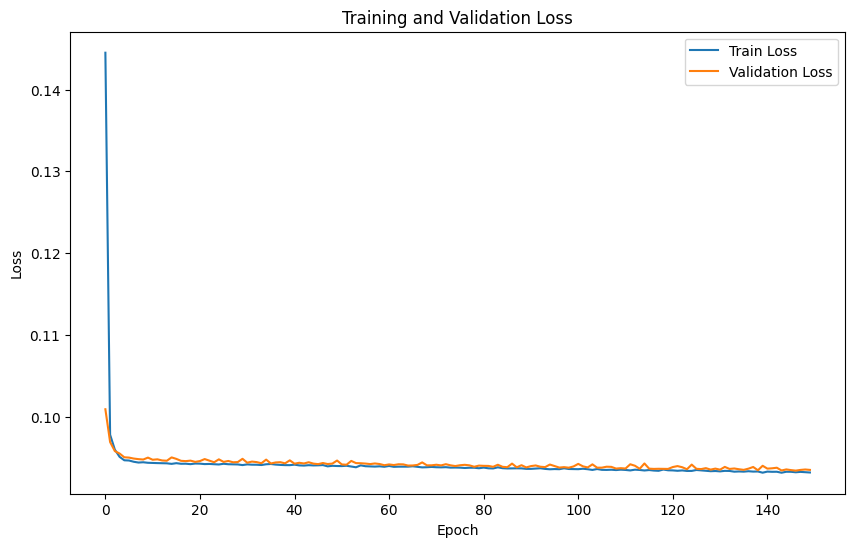

Test RMSE: 0.3057
R^2 Score: 0.0279


In [ ]:
# Define Autoregressive Model
class AutoregressiveModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(AutoregressiveModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:, -1, :])
        return y_pred

input_size = 3
hidden_layer_size = 100
output_size = 2

# Create Autoregressive Model
model = AutoregressiveModel(input_size, hidden_layer_size, output_size)

# Initialize Weights and Biases
for name, param in model.named_parameters():
    if 'weight' in name:
        nn.init.xavier_normal_(param)
    elif 'bias' in name:
        nn.init.uniform_(param, -1, 1)

# Initialize Loss and Optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
NUM_EPOCHS = 150
PATIENCE = 10

# Train Model with Loss Tracking and Early Stopping
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs, patience):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                y_pred = model(sequences)
                loss = loss_function(y_pred, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

train_model(model, train_loader, test_loader, NUM_EPOCHS, PATIENCE)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate Model
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for sequences, targets in test_loader:
            y_pred = model(sequences)
            all_predictions.append(y_pred.numpy())
            all_targets.append(targets.numpy())

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    r2 = r2_score(all_targets, all_predictions)

    print(f'Test RMSE: {rmse:.4f}')
    print(f'R^2 Score: {r2:.4f}')

evaluate_model(model, test_loader)